In [2]:
import os
import skimage
from skimage import io, color ,feature

import numpy as np
import cv2
import re
from skimage.feature import graycomatrix, graycoprops

import pandas as pd

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")


In [5]:
dataset_dir = "/content/drive/My Drive/IIITNR_PROJECT/dataset"
os.listdir(dataset_dir)

['test', 'Train']

In [6]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Initialize lists to store images, labels, and descriptions
imgs = []
labels = []
descs = []

# Function to normalize descriptions (assuming this function is defined elsewhere)
def normalize_desc(folder, sub_folder):
    # Your normalization logic here
    return f"{folder}_{sub_folder}"

# Function to print progress (assuming this function is defined elsewhere)
def print_progress(i, len_sub_folder, folder, sub_folder, filename):
    # Your progress printing logic here
    print(f"Processing {i+1}/{len_sub_folder+1}: {folder}/{sub_folder}/{filename}")

# Function to apply denoising techniques
def apply_denoising_technique(image, technique, params):
    if technique == 'nlm':
        return cv2.fastNlMeansDenoising(image, None, *params)
    elif technique == 'gaussian':
        return cv2.GaussianBlur(image, (params[0], params[0]), params[1])
    elif technique == 'median':
        return cv2.medianBlur(image, params[0])
    elif technique == 'bilateral':
        return cv2.bilateralFilter(image, params[0], params[1], params[2])

# Define the parameter ranges for each technique
parameter_ranges = {
    'nlm': [
        (5, 3, 15), (10, 3, 20), (15, 5, 25),
        (20, 7, 30), (25, 10, 35), (30, 15, 40)
    ],
    'gaussian': [
        (3, 1), (5, 1.5), (7, 2),
        (9, 2.5), (11, 3), (13, 3.5)
    ],
    'median': [
        (3,), (5,), (7,),
        (9,), (11,), (13,)
    ],
    'bilateral': [
        (5, 25, 25), (7, 50, 50), (9, 75, 75),
        (11, 100, 100), (13, 125, 125), (15, 150, 150)
    ]
}


# Initialize a dictionary to store results
results = {tech: {params: {'psnr': [], 'ssim': []} for params in param_list} for tech, param_list in parameter_ranges.items()}

# Iterate through the directory structure
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1

        # Process each image file
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # First thresholding
            _, binary1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

            # Find contours
            contours, _ = cv2.findContours(binary1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Get the largest contour (assuming it is the soil region)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get the bounding box of the largest contour
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Crop the image using the bounding box
            cropped_image = gray[y:y+h, x:x+w]

            # Resize the cropped image
            resized = cv2.resize(cropped_image, (0, 0), fx=0.5, fy=0.5)

            # Ensure the resized image is suitable for SSIM calculation
            if min(resized.shape) < 7:
                continue

            # Evaluate each denoising technique with its parameters on the resized cropped image
            for technique, param_list in parameter_ranges.items():
                for params in param_list:
                    denoised = apply_denoising_technique(resized, technique, params)

                    # Calculate PSNR
                    psnr = peak_signal_noise_ratio(resized, denoised)

                    # Calculate SSIM with explicit win_size parameter
                    win_size = min(resized.shape) if min(resized.shape) % 2 != 0 else min(resized.shape) - 1
                    win_size = max(win_size, 1)
                    ssim = structural_similarity(resized, denoised, win_size=win_size)

                    # Store the PSNR and SSIM values
                    results[technique][params]['psnr'].append(psnr)
                    results[technique][params]['ssim'].append(ssim)

            imgs.append(denoised)
            labels.append(sub_folder)
            descs.append(normalize_desc(folder, sub_folder))

            # Print progress
            print_progress(i, len_sub_folder, folder, sub_folder, filename)

# Calculate the average PSNR and SSIM for each technique and parameter set
average_results = {}
for technique, param_dict in results.items():
    average_results[technique] = {}
    for params, metrics in param_dict.items():
        avg_psnr = np.mean(metrics['psnr'])
        avg_ssim = np.mean(metrics['ssim'])
        average_results[technique][params] = {'avg_psnr': avg_psnr, 'avg_ssim': avg_ssim}

# Print the table of average PSNR and SSIM values
print("Technique\tParameters\t\tAverage PSNR\tAverage SSIM")
for technique, param_dict in average_results.items():
    for params, metrics in param_dict.items():
        print(f"{technique}\t{params}\t{metrics['avg_psnr']:.4f}\t{metrics['avg_ssim']:.4f}")

# Find the best technique and parameters based on average PSNR and SSIM
best_technique = None
best_params = None
best_avg_psnr = -np.inf
best_avg_ssim = -np.inf

for technique, param_dict in average_results.items():
    for params, metrics in param_dict.items():
        if metrics['avg_psnr'] > best_avg_psnr and metrics['avg_ssim'] > best_avg_ssim:
            best_technique = technique
            best_params = params
            best_avg_psnr = metrics['avg_psnr']
            best_avg_ssim = metrics['avg_ssim']

# Output the best technique and parameters
print(f"\nBest Denoising Method: {best_technique}")
print(f"Best Parameters: {best_params}")
print


Processing 1/116: test/Black Soil/Black_1.jpg
Processing 2/116: test/Black Soil/Black_17.jpg
Processing 3/116: test/Black Soil/Black_10.jpg
Processing 4/116: test/Black Soil/Black_11.jpg
Processing 5/116: test/Black Soil/Black_16.jpg
Processing 6/116: test/Black Soil/Black_15.jpg
Processing 7/116: test/Black Soil/Black_14.jpg
Processing 8/116: test/Black Soil/Black_12.jpg
Processing 9/116: test/Black Soil/Black_13.jpg
Processing 10/116: test/Black Soil/Black_31.jpg
Processing 11/116: test/Black Soil/Black_27.jpg
Processing 12/116: test/Black Soil/Black_32.jpg
Processing 13/116: test/Black Soil/Black_25.jpg
Processing 14/116: test/Black Soil/Black_35.jpg
Processing 15/116: test/Black Soil/Black_3.jpg
Processing 16/116: test/Black Soil/Black_33.jpg
Processing 17/116: test/Black Soil/Black_21.jpg
Processing 18/116: test/Black Soil/Black_20.jpg
Processing 19/116: test/Black Soil/Black_36.jpg
Processing 20/116: test/Black Soil/Black_18.jpg
Processing 21/116: test/Black Soil/Black_2.jpg
Proc

<function print>

In [ ]:
len(imgs)

1561

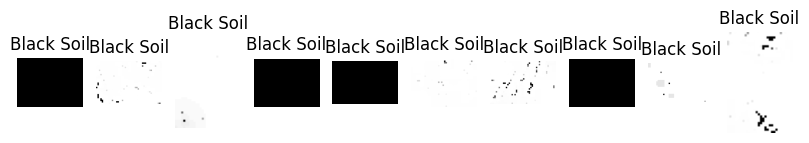

In [ ]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(imgs, labels, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(imgs))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(imgs[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Call the function to display images
display_images(imgs, labels)


In [ ]:
# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):

    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)

    return feature



In [ ]:
# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")


In [ ]:
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

In [ ]:
#knowing dataset
type(glcm_df)
len(glcm_df)
glcm_df.shape

(1561, 25)

In [ ]:
 glcm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dissimilarity_0    1561 non-null   float64
 1   dissimilarity_45   1561 non-null   float64
 2   dissimilarity_90   1561 non-null   float64
 3   dissimilarity_135  1561 non-null   float64
 4   correlation_0      1561 non-null   float64
 5   correlation_45     1561 non-null   float64
 6   correlation_90     1561 non-null   float64
 7   correlation_135    1561 non-null   float64
 8   homogeneity_0      1561 non-null   float64
 9   homogeneity_45     1561 non-null   float64
 10  homogeneity_90     1561 non-null   float64
 11  homogeneity_135    1561 non-null   float64
 12  contrast_0         1561 non-null   float64
 13  contrast_45        1561 non-null   float64
 14  contrast_90        1561 non-null   float64
 15  contrast_135       1561 non-null   float64
 16  ASM_0              1561 

In [ ]:
glcm_df['label'].unique()

array(['Black Soil', 'Clay soil', 'Alluvial soil', 'Red soil'],
      dtype=object)

In [ ]:
glcm_df.head(20)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Black Soil
1,6.322764,5.097070,6.440870,5.407509,-0.013705,-0.013348,-0.015099,-0.010119,0.762279,0.762228,...,967.905678,0.232530,0.244963,0.233630,0.226308,0.482214,0.494937,0.483353,0.475719,Black Soil
2,0.201178,0.170536,0.199519,0.236607,0.128320,0.118004,0.127939,0.108339,0.943358,0.961437,...,3.338393,0.705008,0.741680,0.719492,0.690676,0.839648,0.861209,0.848229,0.831069,Black Soil
3,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Black Soil
4,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Black Soil
5,1.942308,1.626786,1.607744,1.758036,-0.000654,0.002503,-0.009370,0.005625,0.800153,0.773942,...,136.900893,0.256979,0.243556,0.254527,0.232154,0.506931,0.493514,0.504507,0.481824,Black Soil
6,12.405691,13.453297,13.237391,13.564103,0.001162,-0.031043,-0.031315,-0.032132,0.645880,0.635302,...,2595.142857,0.130041,0.135870,0.140855,0.120706,0.360612,0.368605,0.375307,0.347427,Black Soil
7,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Black Soil
8,0.107458,0.122727,0.115451,0.115455,0.067118,-0.012597,-0.014898,-0.010879,0.961751,0.956544,...,0.470000,0.861443,0.845843,0.857078,0.858735,0.928139,0.919697,0.925785,0.926680,Black Soil
9,13.275652,10.644689,8.482114,9.730769,0.040473,0.027429,0.108826,0.124185,0.804011,0.821622,...,2225.282051,0.384341,0.411512,0.408631,0.383978,0.619953,0.641492,0.639243,0.619660,Black Soil


In [ ]:
import matplotlib.pyplot as plt
#important libraries and import
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# Extract features (X) and labels (y) from the DataFrame
X = glcm_df.drop(columns=['label'])  # Features
y = glcm_df['label']  # Labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.fit_transform(X_test)

In [ ]:
svc = SVC()
svc.fit(x_train ,y_train)
pred_svc = svc.predict(x_test)
pred_svc

array(['Alluvial soil', 'Black Soil', 'Black Soil', 'Clay soil',
       'Clay soil', 'Alluvial soil', 'Black Soil', 'Alluvial soil',
       'Red soil', 'Black Soil', 'Alluvial soil', 'Alluvial soil',
       'Alluvial soil', 'Alluvial soil', 'Alluvial soil', 'Black Soil',
       'Black Soil', 'Alluvial soil', 'Alluvial soil', 'Black Soil',
       'Alluvial soil', 'Clay soil', 'Alluvial soil', 'Clay soil',
       'Alluvial soil', 'Black Soil', 'Alluvial soil', 'Alluvial soil',
       'Black Soil', 'Alluvial soil', 'Clay soil', 'Alluvial soil',
       'Alluvial soil', 'Clay soil', 'Alluvial soil', 'Alluvial soil',
       'Clay soil', 'Alluvial soil', 'Alluvial soil', 'Black Soil',
       'Black Soil', 'Alluvial soil', 'Alluvial soil', 'Black Soil',
       'Black Soil', 'Alluvial soil', 'Clay soil', 'Clay soil',
       'Alluvial soil', 'Clay soil', 'Alluvial soil', 'Alluvial soil',
       'Alluvial soil', 'Alluvial soil', 'Alluvial soil', 'Black Soil',
       'Alluvial soil', 'Clay soil', 

In [ ]:
print(classification_report(y_test, pred_svc))

               precision    recall  f1-score   support

Alluvial soil       0.66      0.83      0.73       184
   Black Soil       0.64      0.86      0.73       111
    Clay soil       0.47      0.44      0.46        72
     Red soil       0.63      0.12      0.20       102

     accuracy                           0.62       469
    macro avg       0.60      0.56      0.53       469
 weighted avg       0.62      0.62      0.57       469



In [ ]:
##finding best parameter for our SVC model
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [0.1 ,0.8,0.9,1,1.1,1.2,1.3,1.4,3,5,7,8,9,10,12],
    'kernel' : ['linear' , 'rbf'],
    'gamma' : [0.1 ,0.8,0.9,1,1.1,1.2,1.3,1.4,2,4,6,8,10]

}

grid_svc= GridSearchCV(svc , param_grid = params , scoring = 'accuracy' , cv = 10)

In [ ]:
grid_svc.fit(x_train , y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 3, 5, 7, 8,
                               9, 10, 12],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 2, 4,
                                   6, 8, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [ ]:
grid_svc.best_params_

{'C': 9, 'gamma': 4, 'kernel': 'rbf'}

In [ ]:
svc2 = SVC( C = 5 , gamma = 2 , kernel = 'rbf')
svc2.fit(x_train , y_train)
pred_svc2 = svc2.predict(x_test)
print(classification_report(y_test , pred_svc2))

               precision    recall  f1-score   support

Alluvial soil       0.90      0.89      0.89       184
   Black Soil       0.76      0.90      0.83       111
    Clay soil       0.78      0.69      0.74        72
     Red soil       0.70      0.63      0.66       102

     accuracy                           0.81       469
    macro avg       0.79      0.78      0.78       469
 weighted avg       0.81      0.81      0.80       469

